In [1]:
from utils.libs import *

In [2]:
conf_file_path = 'conf.txt'
conf_data = read_conf_file(conf_file_path)

# pprint(conf_data)

In [3]:
if conf_data['is_single_run']:
    train_df = get_dataframe(conf_data)
else:
    ts_list = '1603410154-248962,1603421693-497763'.split(",")
    # ts_list = '1603421693-497763'.split(",")
    result_dict_df = get_dict_dataframes(conf_data)
    # train_df: pd.DataFrame = result_dict_df['1603410154-248962']
    # train_df: pd.DataFrame = result_dict_df['1603478755-305517']
    
    data = list(map(operator.itemgetter(1), filter(lambda item: item[0] in ts_list, result_dict_df.items())))
    train_df = pd.concat(data)
    print(collections.Counter(train_df['hl']))
    pass

Counter({10.0: 3, 11.0: 3, 12.0: 3, 13.0: 3, 5.0: 2, 7.0: 2, 9.0: 2})


In [4]:
train_df.head(5)

,#params,seed,hl,hf,mse,psnr,ssim,eta
1603410154-248962,21057.0,0.0,5.0,64.0,0.000041,49.973107,0.995740,1196.407052
1603410154-248962,21057.0,42.0,5.0,64.0,0.000045,49.308277,0.995352,1191.496831
1603410154-248962,29377.0,0.0,7.0,64.0,0.000048,47.985887,0.996788,1461.727319
1603410154-248962,29377.0,42.0,7.0,64.0,0.000019,53.524139,0.997652,1493.893317
1603410154-248962,37697.0,0.0,9.0,64.0,0.000011,55.404166,0.998241,1792.826098


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 1603410154-248962 to 1603421693-497763
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   #params  18 non-null     float64
 1   seed     18 non-null     float64
 2   hl       18 non-null     float64
 3   hf       18 non-null     float64
 4   mse      18 non-null     float64
 5   psnr     18 non-null     float64
 6   ssim     18 non-null     float64
 7   eta      18 non-null     float64
dtypes: float64(8)
memory usage: 1.3+ KB


In [6]:
train_df.describe()

,#params,seed,hl,hf,mse,psnr,ssim,eta
count,18.000000,18.000000,18.000000,18.0,18.000000,18.000000,18.000000,18.000000
mean,41857.000000,43.666667,10.000000,64.0,0.000034,52.491651,0.997128,1912.219564
std,10677.704093,47.614877,2.566756,0.0,0.000047,3.714559,0.001586,362.864344
min,21057.000000,0.000000,5.000000,64.0,0.000009,41.880483,0.992691,1191.496831
25%,37697.000000,0.000000,9.000000,64.0,0.000011,50.215942,0.996499,1795.524451
50%,43937.000000,42.000000,10.500000,64.0,0.000018,53.843995,0.997624,1992.071780
75%,50177.000000,42.000000,12.000000,64.0,0.000038,55.348077,0.998268,2184.664388
max,54337.000000,123.000000,13.000000,64.0,0.000211,55.984903,0.998540,2337.905498


Image size: (512, 512)


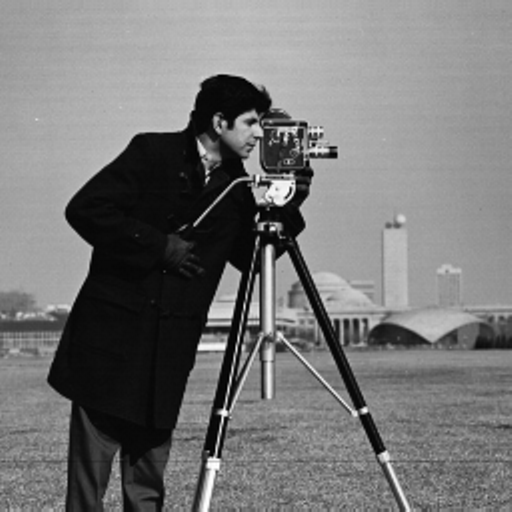

In [7]:
# Load target image.
im = load_target_image(image_file_path = None)
print('Image size:', im.size)
im

In [8]:
crop_size = conf_data['cropped_image']['crop_size']
if isinstance(crop_size, str):
    crop_size = eval(crop_size)
elif isinstance(crop_size, int):
    crop_size = (crop_size, crop_size)
    pass
type(crop_size[0])

int

Image size: (512, 512)


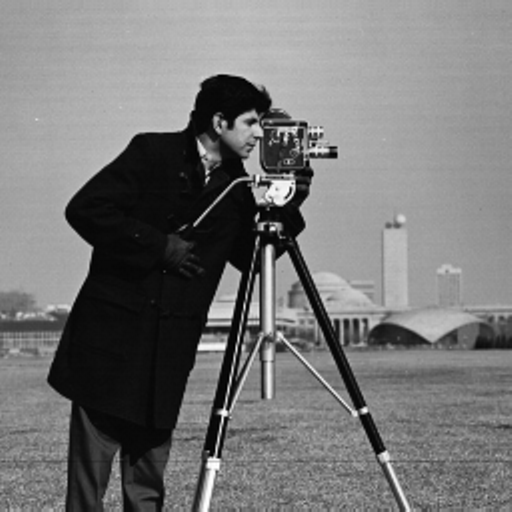

In [9]:
if conf_data['cropped_image']['flag'] is True:
    im_cropped = get_cropped_by_center_image(im, target = crop_size)
    pass
else:
    im_cropped = im
print('Image size:', im_cropped.size)
im_cropped

In [10]:
# Array of qualities to be tested in compression.
qualities_arr = np.arange(20, 95+1, dtype = np.int)

In [11]:
# Run several trials for JPEG compression.

cropped_file_size_bits = None

# im_cropped = im
# im_cropped = Image.fromarray(skimage.data.camera())
with BytesIO() as f:
    im_cropped.save(f, format='PNG')
    cropped_file_size_bits = f.getbuffer().nbytes * 8
    pass

result_tuples, failure_qualities = \
  calculate_several_jpeg_compression(im_cropped, cropped_file_size_bits, qualities_arr)

In [12]:
# data = list(map(lambda xx: xx._asdict(), result_tuples))
data = list(map(operator.methodcaller('_asdict'), result_tuples))
result_jpeg_df = pd.DataFrame(data = data)
result_jpeg_df.head(5)

,psnr,ssim,quality,file_size_bits,bpp,width,heigth,CR
0,34.736878,0.926260,20,88800,0.338745,512,512,10.470541
1,34.951488,0.928083,21,91568,0.349304,512,512,10.154028
2,35.139054,0.930282,22,94080,0.358887,512,512,9.882908
3,35.367639,0.933188,23,96232,0.367096,512,512,9.661900
4,35.549608,0.935449,24,98584,0.376068,512,512,9.431388


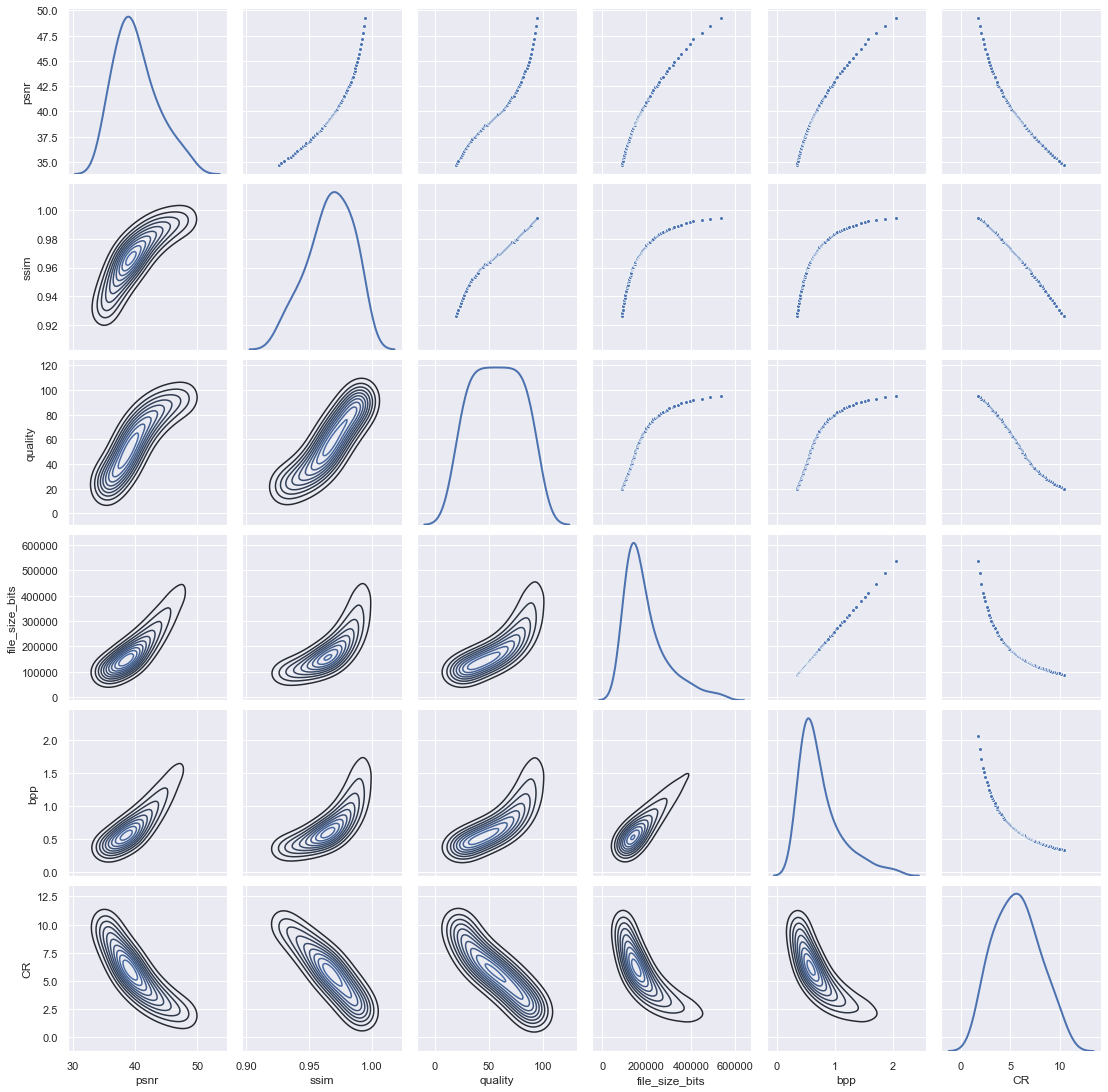

In [13]:
# sns.pairplot(results_history_df)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    try:
        g = sns.PairGrid(result_jpeg_df.drop(['width', 'heigth'], axis = 1), diag_sharey=False)
        g.map_upper(sns.scatterplot, s=15) # 
        g.map_lower(sns.kdeplot)
        g.map_diag(sns.kdeplot, lw=2)
        # plt.savefig(f"{images_conf.df_jpeg_scatterplot}")
    except Exception as err:
        print(str(err))
        pass
    pass

In [14]:
train_df['bpp'] = train_df['#params'].values * 32 / (im_cropped.size[0] * im_cropped.size[1])

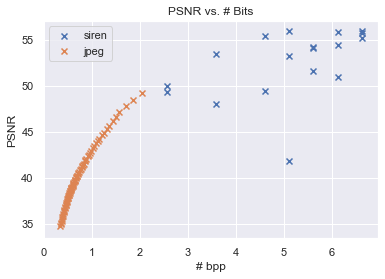

In [15]:
compare_compressions(compression_1_df=train_df, compression_2_df=result_jpeg_df)

In [16]:
result_jpeg_df.columns, train_df.columns

(Index(['psnr', 'ssim', 'quality', 'file_size_bits', 'bpp', 'width', 'heigth',
        'CR'],
       dtype='object'),
 Index(['#params', 'seed', 'hl', 'hf', 'mse', 'psnr', 'ssim', 'eta', 'bpp'], dtype='object'))

In [17]:
result_jpeg_df['compression'] = ['jpeg'] * result_jpeg_df.shape[0]
train_df['compression'] = ['siren'] * train_df.shape[0]
train_df['file_size_bits'] = train_df['#params'].values * 32
train_df['CR'] = cropped_file_size_bits / train_df['#params'].values * 32

In [18]:
result_jpeg_df.columns, train_df.columns

(Index(['psnr', 'ssim', 'quality', 'file_size_bits', 'bpp', 'width', 'heigth',
        'CR', 'compression'],
       dtype='object'),
 Index(['#params', 'seed', 'hl', 'hf', 'mse', 'psnr', 'ssim', 'eta', 'bpp',
        'compression', 'file_size_bits', 'CR'],
       dtype='object'))

In [19]:
train_df_columns_for_merge = "psnr,ssim,CR,bpp,file_size_bits,compression".split(",")
result_jpeg_df_columns_for_merge = "psnr,ssim,CR,bpp,file_size_bits,compression".split(",")

data_frames_list = [
    train_df[train_df_columns_for_merge],
    result_jpeg_df[result_jpeg_df_columns_for_merge],
]
merged_df = pd.concat(data_frames_list, names = "psnr,ssim,CRbpp,file_size_bits,compression".split(","))

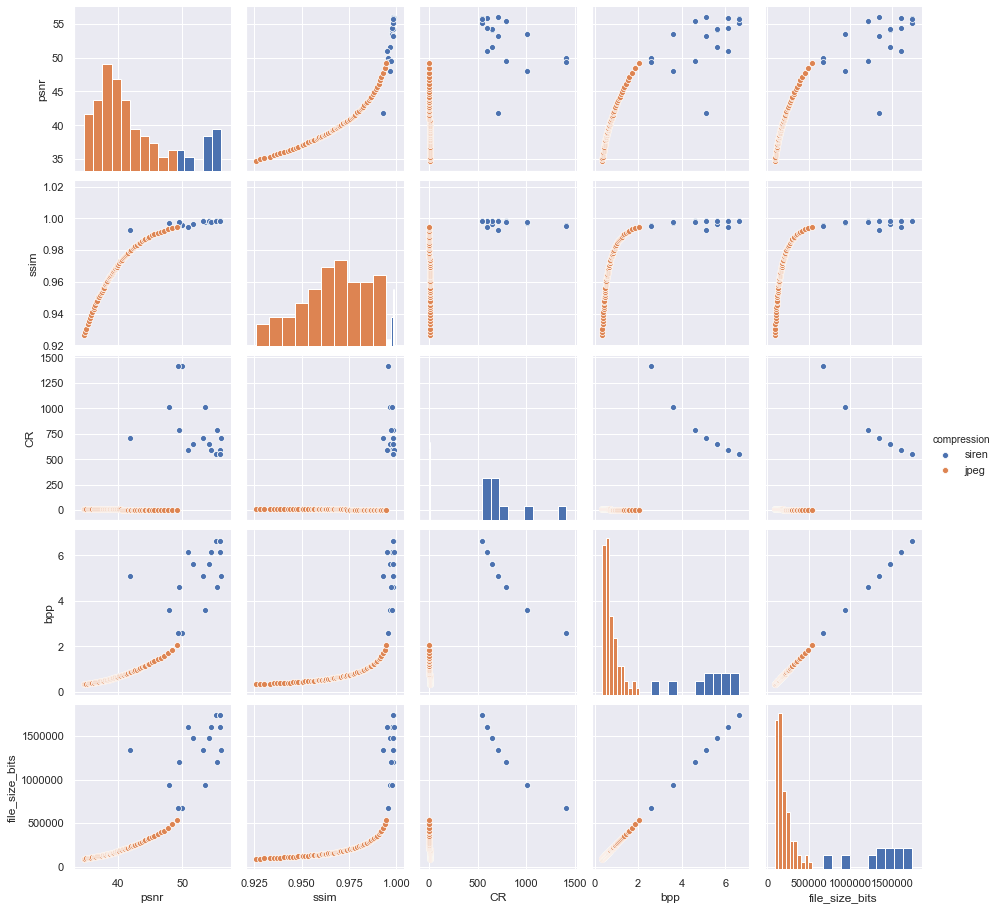

In [20]:
g = sns.PairGrid(merged_df, hue="compression")
g.map_diag(plt.hist)
g.map_offdiag(sns.scatterplot)
g.add_legend()
# g.savefig("scatter_plot_dataframes_merged.png")
plt.show()

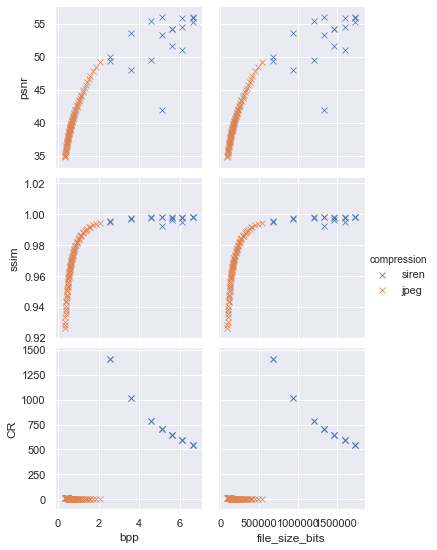

In [21]:
x_vars = "bpp,file_size_bits".split(",")
y_vars = "psnr,ssim,CR".split(",")
hue = "compression"

g = sns.PairGrid(merged_df, x_vars=x_vars, y_vars=y_vars, hue=hue)
g.map(sns.scatterplot, marker='x')
g.add_legend()

# g.savefig("compare_compressions_metrices.png")

plt.show()

In [25]:
sns.__version__

'0.10.0'

In [36]:
?sns.jointplot

In [26]:
# sns.jointplot(data=merged_df, x="bpp", y="psnr", hue="compression")

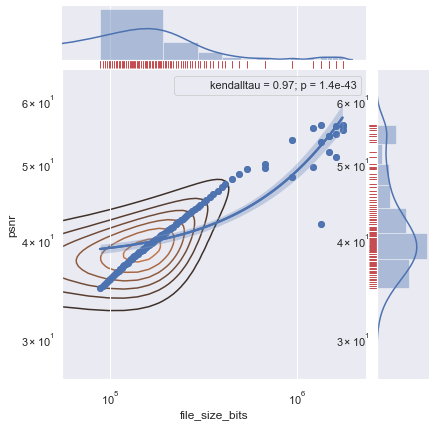

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("file_size_bits", "psnr",
            kind="reg",
            data=merged_df,
            color="b",
            # annot_kws=dict(stat="r"),
            stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

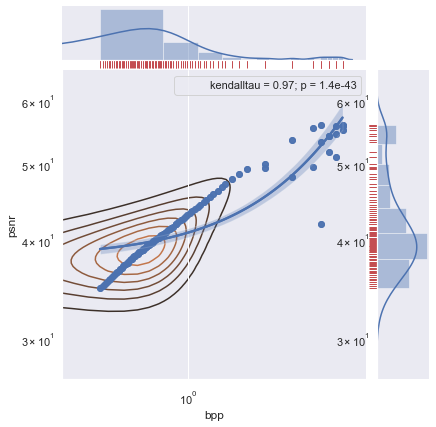

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("bpp", "psnr",
        kind="reg",
        data=merged_df, color="b", stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

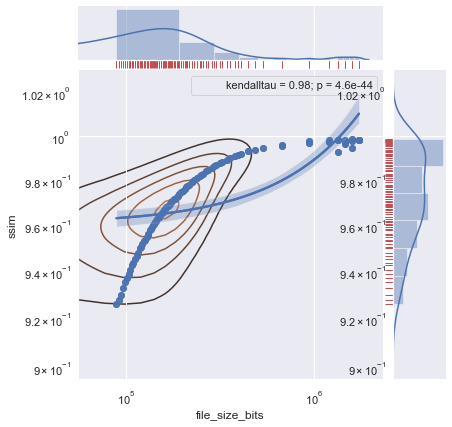

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("file_size_bits", "ssim",
        kind="reg",
        data=merged_df, color="b", stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

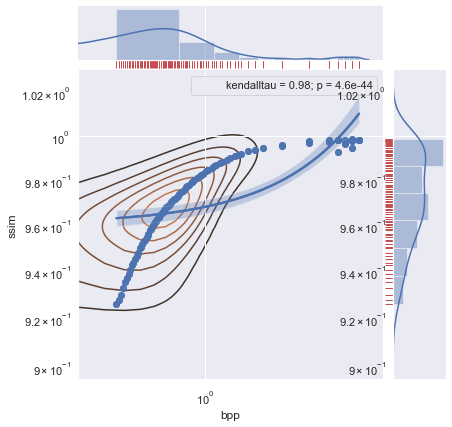

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("bpp", "ssim",
        kind="reg",
        data=merged_df, color="b", stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

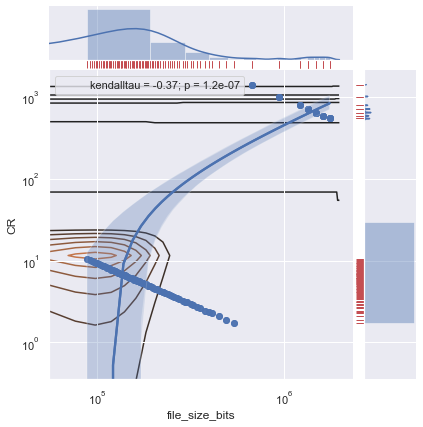

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("file_size_bits", "CR",
        kind="reg",
        data=merged_df, color="b", stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

TypeError: regplot() got an unexpected keyword argument 'hue'

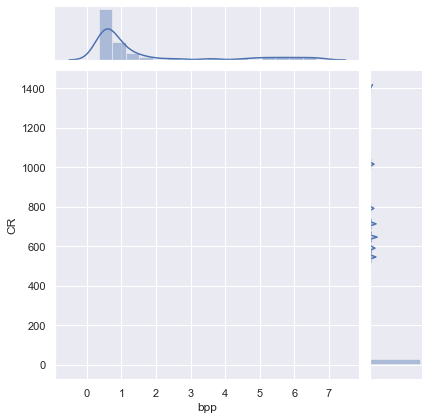

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    g = (sns.jointplot("bpp", "CR",
        kind="reg",
        data=merged_df, color="b", stat_func=scipy.stats.kendalltau,)
        .plot_joint(sns.kdeplot, zorder=0, n_levels=6)
        .plot_joint(sns.regplot, color="b"))
    g.plot_marginals(sns.rugplot, color="r", height=-.15, clip_on=False)
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    pass

[Lib/statistics.py](https://docs.python.org/3/library/statistics.html)